# Interactive Evaluation Results Plotting

This notebook allows you to interactively select which models to plot from your evaluation results.

You can easily toggle models on/off and customize the plot appearance.

## 1. Configuration

Select which models you want to plot by setting them to `True` or `False`:

In [1]:
import os
import sys
from pathlib import Path

# Add parent directory to path to import plotting functions
notebook_dir = Path(os.getcwd())
if 'notebooks' in str(notebook_dir):
    project_root = notebook_dir.parent.parent
else:
    project_root = notebook_dir
sys.path.insert(0, str(project_root / "SD_pusht" / "scripts"))

# Base directory containing model folders
BASE_DIR = "log/dp"  # Relative to project root
OUTPUT_DIR = "plots"  # Where to save plots (relative to project root)

# ============================================================================
# EASY MODEL SELECTION - Just list the models you want to plot!
# ============================================================================
# Available model types:
#   - 'diffusion': Diffusion Policy
#   - 'flow_matching': Flow Matching Policy
#   - 'local_flow_2d': Local Flow 2D (Legacy)
#   - 'local_flow_2d_median_concat': Local Flow 2D: Median Aggregation, Concatenation
#   - 'local_flow_2d_knn_concat': Local Flow 2D: KNN Aggregation, Concatenation
#   - 'local_flow_2d_median_film': Local Flow 2D: Median Aggregation, FiLM Conditioning
#   - 'local_flow_2d_knn_film': Local Flow 2D: KNN Aggregation, FiLM Conditioning
#
# Example: To plot only local_flow_2d and local_flow_2d_knn_film:
#   SELECTED_MODELS = ['local_flow_2d', 'local_flow_2d_knn_film']
# ============================================================================

SELECTED_MODELS = [
    'local_flow_2d',
    'local_flow_2d_knn_film',
    # Add more models here as needed:
    # 'diffusion',
    # 'flow_matching',
    # 'local_flow_2d_median_concat',
    # 'local_flow_2d_knn_concat',
    # 'local_flow_2d_median_film',
]

# Convert list to dictionary for compatibility
MODEL_SELECTION = {model: True for model in SELECTED_MODELS}

# Plot settings
FIGURE_SIZE = (16, 6)  # (width, height) in inches
LEGEND_FONTSIZE = 10
DPI = 300  # Resolution for saved plots

print(f"Project root: {project_root}")
print(f"Base directory: {BASE_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"\nSelected models ({len(SELECTED_MODELS)}):")
for model in SELECTED_MODELS:
    print(f"  ✓ {model}")

Project root: /proj/rep-learning-robotics/users/x_alblo/SpatialDecompositionPusht
Base directory: log/dp
Output directory: plots

Selected models:
  ✓ diffusion
  ✓ flow_matching
  ✓ local_flow_2d
  ✓ local_flow_2d_median_concat
  ✓ local_flow_2d_knn_concat
  ✓ local_flow_2d_median_film
  ✓ local_flow_2d_knn_film


## 2. Load Evaluation Results

Load all available evaluation results from the base directory:

In [2]:
import numpy as np
from collections import defaultdict
import json
import re

def parse_model_name(folder_name):
    """Parse model folder name to extract model type and number of demos."""
    # Match pattern: sd-pusht-{type}-demos-{num}-seed{seed}
    match = re.match(r'sd-pusht-(diffusion|fm)-demos-(\d+)-seed\d+', folder_name)
    if match:
        model_type = 'diffusion' if match.group(1) == 'diffusion' else 'flow_matching'
        num_demos = int(match.group(2))
        return model_type, num_demos
    
    # Match pattern for local flow 2D with aggregation and FiLM
    match = re.match(r'sd-pusht-local-flow-2d_V\d+-demos-(\d+)-seed\d+-(?:no-)?share-noise-(?:gt-|pred-)ref-(concat|film)-(median|knn)', folder_name)
    if match:
        num_demos = int(match.group(1))
        film_str = match.group(2)  # 'concat' or 'film'
        agg_str = match.group(3)   # 'median' or 'knn'
        model_type = f'local_flow_2d_{agg_str}_{film_str}'
        return model_type, num_demos
    
    # Match pattern for local flow 2D with only FiLM (defaults to median)
    match = re.match(r'sd-pusht-local-flow-2d_V\d+-demos-(\d+)-seed\d+-(?:no-)?share-noise-(?:gt-|pred-)ref-(concat|film)$', folder_name)
    if match:
        num_demos = int(match.group(1))
        film_str = match.group(2)  # 'concat' or 'film'
        agg_str = 'median'  # Default to median if not specified
        model_type = f'local_flow_2d_{agg_str}_{film_str}'
        return model_type, num_demos
    
    # Fallback: Match pattern for older local flow 2D without aggregation/FiLM suffix
    match = re.match(r'sd-pusht-local-flow-2d_V\d+-demos-(\d+)-seed\d+', folder_name)
    if match:
        model_type = 'local_flow_2d'
        num_demos = int(match.group(1))
        return model_type, num_demos
    
    return None, None


def load_eval_results(base_dir):
    """Load all evaluation results from model folders."""
    results = defaultdict(lambda: defaultdict(list))
    
    # Convert to absolute path if relative
    if not os.path.isabs(base_dir):
        base_path = project_root / base_dir
    else:
        base_path = Path(base_dir)
    
    if not base_path.exists():
        print(f"Warning: Base directory {base_path} does not exist!")
        return results
    
    # Find all model folders
    for model_folder in base_path.iterdir():
        if not model_folder.is_dir():
            continue
        
        # Check if eval_results directory exists
        eval_results_dir = model_folder / "eval_results"
        npz_path = eval_results_dir / "eval_results.npz"
        
        if not npz_path.exists():
            continue
        
        # Load npz file
        try:
            data = np.load(npz_path, allow_pickle=True)
            
            # Always parse model type from folder name first (has the most detailed info)
            model_type, num_demos = parse_model_name(model_folder.name)
            
            if model_type is None or num_demos is None:
                # Fallback: try to get from config
                config_path = model_folder / "config.json"
                if config_path.exists():
                    try:
                        with open(config_path, 'r') as f:
                            config = json.load(f)
                        num_demos = config.get('max_demos', None)
                        if 'model_type' in config:
                            model_type = config['model_type']
                    except Exception:
                        pass
                
                if model_type is None or num_demos is None:
                    print(f"Warning: Could not parse model name: {model_folder.name}")
                    continue
            
            # Extract metrics
            success_rate = float(data['success_rate'])
            
            if 'mean_max_single_reward' in data:
                mean_max_single_reward = float(data['mean_max_single_reward'])
            else:
                print(f"Warning: mean_max_single_reward not found in {npz_path}, skipping...")
                continue
            
            # Get dataset dimensions from config.json if available
            config_path = model_folder / "config.json"
            obs_dim = None
            action_dim = None
            
            if config_path.exists():
                try:
                    with open(config_path, 'r') as f:
                        config = json.load(f)
                    obs_dim = config.get('obs_dim', None)
                    action_dim = config.get('action_dim', None)
                except Exception as e:
                    pass
            
            # If not in config, try to get from npz
            if obs_dim is None:
                obs_dim = int(data.get('obs_dim', 5))
            if action_dim is None:
                action_dim = int(data.get('action_dim', 2))
            
            # Create dimension key
            dim_key = f"obs_dim={obs_dim},action_dim={action_dim}"
            
            # Store results (only if model is selected)
            if MODEL_SELECTION.get(model_type, False):
                results[dim_key][model_type].append((num_demos, success_rate, mean_max_single_reward))
        
        except Exception as e:
            print(f"Warning: Could not load results from {npz_path}: {e}")
            continue
    
    # Sort by num_demos for each model type
    for dim_key in results:
        for model_type in results[dim_key]:
            results[dim_key][model_type].sort(key=lambda x: x[0])
    
    return results


# Load results
print(f"Loading evaluation results from: {BASE_DIR}")
all_results = load_eval_results(BASE_DIR)

print(f"\nFound results for {len(all_results)} dimension group(s):")
for dim_key, dim_results in all_results.items():
    print(f"  {dim_key}:")
    for model_type, data_list in dim_results.items():
        print(f"    {model_type}: {len(data_list)} models")

Loading evaluation results from: log/dp

Found results for 1 dimension group(s):
  obs_dim=5,action_dim=2:
    diffusion: 6 models
    flow_matching: 6 models
    local_flow_2d: 6 models
    local_flow_2d_median_concat: 12 models
    local_flow_2d_knn_concat: 6 models
    local_flow_2d_median_film: 12 models
    local_flow_2d_knn_film: 6 models


## 3. Create Plots

Create plots with the selected models:

Saved plot to: /proj/rep-learning-robotics/users/x_alblo/SpatialDecompositionPusht/plots/eval_results_obs_dim5_action_dim2.png


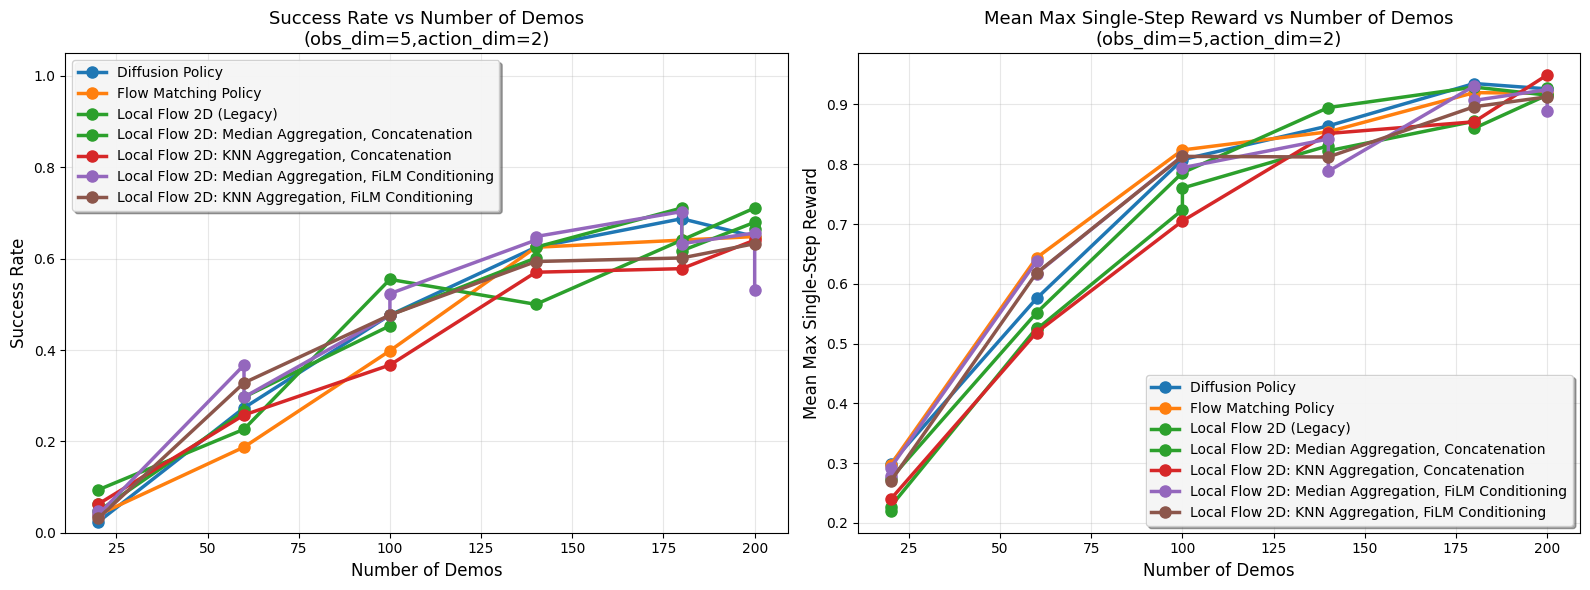

In [3]:
import matplotlib.pyplot as plt

# Colors for different model types
colors = {
    'diffusion': '#1f77b4',  # blue
    'flow_matching': '#ff7f0e',  # orange
    'local_flow_2d': '#2ca02c',  # green (legacy)
    'local_flow_2d_median_concat': '#2ca02c',  # green (baseline)
    'local_flow_2d_knn_concat': '#d62728',  # red (KNN)
    'local_flow_2d_median_film': '#9467bd',  # purple (FiLM)
    'local_flow_2d_knn_film': '#8c564b'  # brown (KNN + FiLM)
}

# Labels for model types
labels = {
    'diffusion': 'Diffusion Policy',
    'flow_matching': 'Flow Matching Policy',
    'local_flow_2d': 'Local Flow 2D (Legacy)',
    'local_flow_2d_median_concat': 'Local Flow 2D: Median Aggregation, Concatenation',
    'local_flow_2d_knn_concat': 'Local Flow 2D: KNN Aggregation, Concatenation',
    'local_flow_2d_median_film': 'Local Flow 2D: Median Aggregation, FiLM Conditioning',
    'local_flow_2d_knn_film': 'Local Flow 2D: KNN Aggregation, FiLM Conditioning'
}

# Plot order (for consistent ordering in legend)
plot_order = ['diffusion', 'flow_matching', 'local_flow_2d',
             'local_flow_2d_median_concat', 'local_flow_2d_knn_concat',
             'local_flow_2d_median_film', 'local_flow_2d_knn_film']


def create_plots(results, output_dir=None, show_plots=True, save_plots=True):
    """Create plots for evaluation results with selected models only."""
    # Convert to absolute path if relative
    if output_dir and not os.path.isabs(output_dir):
        output_dir = str(project_root / output_dir)
    elif output_dir is None:
        output_dir = str(project_root / "plots")
    
    if save_plots:
        os.makedirs(output_dir, exist_ok=True)
    
    # Create plots for each dimension group
    for dim_key, dim_results in results.items():
        # Filter to only include selected models
        filtered_results = {k: v for k, v in dim_results.items() 
                          if MODEL_SELECTION.get(k, False) and len(v) > 0}
        
        if not filtered_results:
            print(f"No selected models found for {dim_key}")
            continue
        
        # Prepare data for plotting
        plot_data = {}
        for model_type, data_list in filtered_results.items():
            if data_list:
                # Sort by num_demos to ensure proper line plotting
                sorted_data = sorted(data_list, key=lambda x: x[0])
                num_demos = [x[0] for x in sorted_data]
                success_rates = [x[1] for x in sorted_data]
                mean_max_rewards = [x[2] for x in sorted_data]
                if len(num_demos) > 0:
                    plot_data[model_type] = {
                        'num_demos': num_demos,
                        'success_rates': success_rates,
                        'mean_max_rewards': mean_max_rewards
                    }
        
        if not plot_data:
            continue
        
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=FIGURE_SIZE)
        
        # Plot 1: Success Rate vs Number of Demos
        for model_type in plot_order:
            if model_type in plot_data:
                data = plot_data[model_type]
                ax1.plot(
                    data['num_demos'],
                    data['success_rates'],
                    'o-',
                    color=colors.get(model_type, '#000000'),
                    label=labels.get(model_type, model_type),
                    linewidth=2.5,
                    markersize=8
                )
        
        # Plot any remaining models not in predefined order
        for model_type, data in plot_data.items():
            if model_type not in plot_order:
                ax1.plot(
                    data['num_demos'],
                    data['success_rates'],
                    'o-',
                    color=colors.get(model_type, '#000000'),
                    label=labels.get(model_type, model_type),
                    linewidth=2.5,
                    markersize=8
                )
        
        ax1.set_xlabel('Number of Demos', fontsize=12)
        ax1.set_ylabel('Success Rate', fontsize=12)
        ax1.set_title(f'Success Rate vs Number of Demos\n({dim_key})', fontsize=13)
        ax1.legend(loc='best', fontsize=LEGEND_FONTSIZE, framealpha=0.9, fancybox=True, shadow=True)
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim([0, 1.05])
        
        # Plot 2: Mean Max Single-Step Reward vs Number of Demos
        for model_type in plot_order:
            if model_type in plot_data:
                data = plot_data[model_type]
                ax2.plot(
                    data['num_demos'],
                    data['mean_max_rewards'],
                    'o-',
                    color=colors.get(model_type, '#000000'),
                    label=labels.get(model_type, model_type),
                    linewidth=2.5,
                    markersize=8
                )
        
        # Plot any remaining models not in predefined order
        for model_type, data in plot_data.items():
            if model_type not in plot_order:
                ax2.plot(
                    data['num_demos'],
                    data['mean_max_rewards'],
                    'o-',
                    color=colors.get(model_type, '#000000'),
                    label=labels.get(model_type, model_type),
                    linewidth=2.5,
                    markersize=8
                )
        
        ax2.set_xlabel('Number of Demos', fontsize=12)
        ax2.set_ylabel('Mean Max Single-Step Reward', fontsize=12)
        ax2.set_title(f'Mean Max Single-Step Reward vs Number of Demos\n({dim_key})', fontsize=13)
        ax2.legend(loc='best', fontsize=LEGEND_FONTSIZE, framealpha=0.9, fancybox=True, shadow=True)
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure
        if save_plots:
            filename_dim_key = dim_key.replace(',', '_').replace('=', '')
            output_path = os.path.join(output_dir, f'eval_results_{filename_dim_key}.png')
            plt.savefig(output_path, dpi=DPI, bbox_inches='tight')
            print(f"Saved plot to: {output_path}")
        
        if show_plots:
            plt.show()
        else:
            plt.close(fig)


# Create plots
create_plots(all_results, output_dir=OUTPUT_DIR, show_plots=True, save_plots=True)

## 4. Optional: Create Individual Plots

Create separate plots for success rate and mean max reward:

In [ ]:
def create_individual_plots(results, output_dir=None, show_plots=True, save_plots=True):
    """Create individual plots for success rate and mean max reward."""
    if output_dir and not os.path.isabs(output_dir):
        output_dir = str(project_root / output_dir)
    elif output_dir is None:
        output_dir = str(project_root / "plots")
    
    if save_plots:
        os.makedirs(output_dir, exist_ok=True)
    
    for dim_key, dim_results in results.items():
        # Filter to only include selected models
        filtered_results = {k: v for k, v in dim_results.items() 
                          if MODEL_SELECTION.get(k, False) and len(v) > 0}
        
        if not filtered_results:
            continue
        
        # Prepare data
        plot_data = {}
        for model_type, data_list in filtered_results.items():
            if data_list:
                sorted_data = sorted(data_list, key=lambda x: x[0])
                num_demos = [x[0] for x in sorted_data]
                success_rates = [x[1] for x in sorted_data]
                mean_max_rewards = [x[2] for x in sorted_data]
                if len(num_demos) > 0:
                    plot_data[model_type] = {
                        'num_demos': num_demos,
                        'success_rates': success_rates,
                        'mean_max_rewards': mean_max_rewards
                    }
        
        if not plot_data:
            continue
        
        filename_dim_key = dim_key.replace(',', '_').replace('=', '')
        
        # Plot 1: Success Rate only
        fig1, ax1_only = plt.subplots(1, 1, figsize=(10, 6))
        for model_type in plot_order:
            if model_type in plot_data:
                data = plot_data[model_type]
                ax1_only.plot(
                    data['num_demos'],
                    data['success_rates'],
                    'o-',
                    color=colors.get(model_type, '#000000'),
                    label=labels.get(model_type, model_type),
                    linewidth=2.5,
                    markersize=8
                )
        for model_type, data in plot_data.items():
            if model_type not in plot_order:
                ax1_only.plot(
                    data['num_demos'],
                    data['success_rates'],
                    'o-',
                    color=colors.get(model_type, '#000000'),
                    label=labels.get(model_type, model_type),
                    linewidth=2.5,
                    markersize=8
                )
        ax1_only.set_xlabel('Number of Demos', fontsize=12)
        ax1_only.set_ylabel('Success Rate', fontsize=12)
        ax1_only.set_title(f'Success Rate vs Number of Demos\n({dim_key})', fontsize=13)
        ax1_only.legend(loc='best', fontsize=LEGEND_FONTSIZE, framealpha=0.9, fancybox=True, shadow=True)
        ax1_only.grid(True, alpha=0.3)
        ax1_only.set_ylim([0, 1.05])
        plt.tight_layout()
        if save_plots:
            output_path1 = os.path.join(output_dir, f'success_rate_{filename_dim_key}.png')
            plt.savefig(output_path1, dpi=DPI, bbox_inches='tight')
            print(f"Saved success rate plot to: {output_path1}")
        if show_plots:
            plt.show()
        else:
            plt.close(fig1)
        
        # Plot 2: Mean Max Reward only
        fig2, ax2_only = plt.subplots(1, 1, figsize=(10, 6))
        for model_type in plot_order:
            if model_type in plot_data:
                data = plot_data[model_type]
                ax2_only.plot(
                    data['num_demos'],
                    data['mean_max_rewards'],
                    'o-',
                    color=colors.get(model_type, '#000000'),
                    label=labels.get(model_type, model_type),
                    linewidth=2.5,
                    markersize=8
                )
        for model_type, data in plot_data.items():
            if model_type not in plot_order:
                ax2_only.plot(
                    data['num_demos'],
                    data['mean_max_rewards'],
                    'o-',
                    color=colors.get(model_type, '#000000'),
                    label=labels.get(model_type, model_type),
                    linewidth=2.5,
                    markersize=8
                )
        ax2_only.set_xlabel('Number of Demos', fontsize=12)
        ax2_only.set_ylabel('Mean Max Single-Step Reward', fontsize=12)
        ax2_only.set_title(f'Mean Max Single-Step Reward vs Number of Demos\n({dim_key})', fontsize=13)
        ax2_only.legend(loc='best', fontsize=LEGEND_FONTSIZE, framealpha=0.9, fancybox=True, shadow=True)
        ax2_only.grid(True, alpha=0.3)
        plt.tight_layout()
        if save_plots:
            output_path2 = os.path.join(output_dir, f'mean_max_reward_{filename_dim_key}.png')
            plt.savefig(output_path2, dpi=DPI, bbox_inches='tight')
            print(f"Saved mean max reward plot to: {output_path2}")
        if show_plots:
            plt.show()
        else:
            plt.close(fig2)


# Uncomment to create individual plots
# create_individual_plots(all_results, output_dir=OUTPUT_DIR, show_plots=True, save_plots=True)